# Assumptions
Several assumptions are made to price vanilla European options, :

*   European options can only be exercised at expiration.
*   The spot price follows a lognormal distribution.

*   The risk-free rate r and volatility $\sigma$ are constant.
*   Market movements cannot be predicted.








# Imports

In [ ]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

We define here the results of the Black Scholes stochastic equation leading to an estimation of the options' prices using log-normal assumption on the spot price, fixed strike, time to maturity, interest rate, dividend rate and volatility. We will see that fixing volatility constant is not always a good idea but here is a baseline for European options pricing with dividends.

In [ ]:
def black_scholes_dividends(S, K, T, r, q, sigma,typeoption):
    #S: spot price of the asset at time t
    #K: strike price of the optuib
    #T: time to maturity
    #r: interest rate assumed constant between t and T
    #q: rate of continuous dividend paying asset 
    #sigma: volatility of underlying asset
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if typeoption == 'call':
      call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
      option = call
    elif typeoption == 'put':
      put = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0))
      option = put 
    return option

# We can now look at the variation of the option's price due to the variation of the spot price S$_t$ using the Dividend Paying Black-Scholes Formula.

Increasing the spot price leads to increasing call value and decreasing put value.

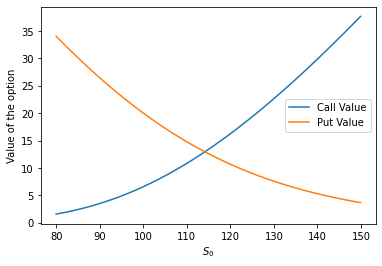

In [ ]:
S_0 = 80
S = np.arange(80,150,0.1)
K = 120
T = 1
r = 0.1
q = 0.05
sigma = 0.3

calls = [black_scholes_dividends(s, K, T, r,q,sigma,'call') for s in S]
puts = [black_scholes_dividends(s, K, T, r,q,sigma,'put') for s in S]
plt.plot(S, calls, label='Call Value')
plt.plot(S, puts, label='Put Value')
plt.xlabel('$S_0$')
plt.ylabel('Value of the option')
plt.legend()

# We may display the variation of the option's price due to the variation of the dividend q.

As expected a higher dividend with all the other parameters fixed will lead to higher put value and smaller call value.

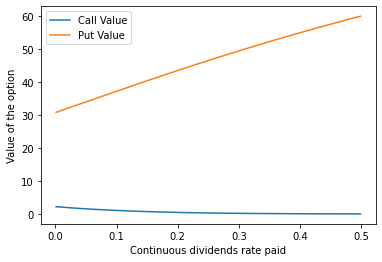

In [ ]:
dividends = np.arange(0.001,0.5,0.001)

calls = [black_scholes_dividends(S_0, K, T, r,q,sigma,'call') for q in dividends]
puts = [black_scholes_dividends(S_0, K, T, r,q,sigma,'put') for q in dividends]
plt.plot(dividends, calls, label='Call Value')
plt.plot(dividends, puts, label='Put Value')
plt.xlabel('Continuous dividends rate paid')
plt.ylabel('Value of the option')
plt.legend()

# We can also look at the variation of the option's price due to the variation of the volatility σ using the Dividend Paying Black-Scholes Formula.

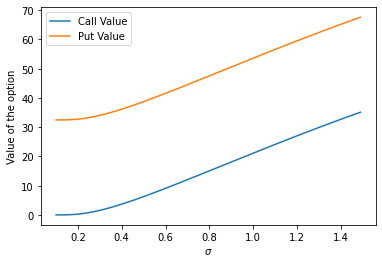

In [ ]:
sigmas = np.arange(0.1, 1.5, 0.01)
calls = [black_scholes_dividends(S_0, K, T, r,q,sigma,'call') for sigma in sigmas]
puts = [black_scholes_dividends(S_0, K, T, r,q,sigma,'put') for sigma in sigmas]
plt.plot(sigmas, calls, label='Call Value')
plt.plot(sigmas, puts, label='Put Value')
plt.xlabel('$\sigma$')
plt.ylabel('Value of the option')
plt.legend()

# Effect of Time on Black-Scholes Price

Increasing the time to maturity of an option will lead to an increasing call value and a decreasing put value. This could be explained by the fact that the longer the time to maturity the more risks we could encounter due to the market's volatility.

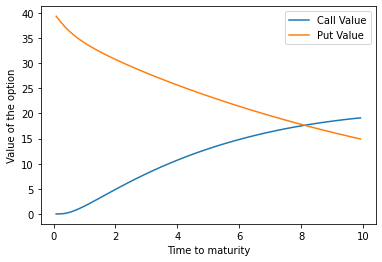

In [ ]:
Maturity_Times = np.arange(1/12, 10, 1/12) # Maturity will take value from 1 month to 10 years.

calls = [black_scholes_dividends(S_0, K, T, r,q,sigma,'call') for T in Maturity_Times]
puts = [black_scholes_dividends(S_0, K, T, r,q,sigma,'put') for T in Maturity_Times]
plt.plot(Maturity_Times, calls, label='Call Value')
plt.plot(Maturity_Times, puts, label='Put Value')
plt.xlabel('Time to maturity')
plt.ylabel('Value of the option')
plt.legend()

Several problems arise using Black Scholes. Indeed, for the whole time to maturity we assume that the volatilty $\sigma$ is constant while movements in the assets and the underlying may happend due to external events. In this case we see Black-Scholes'limits and could lead to implement stochastic equations on the volatility to take those variations into account. That is why if the model does not fit the ground truth, changements need to be made to the model  to fit reality.

In [ ]:
stock_ticker = 'AAPL'
start = pd.to_datetime(['2010-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2020-10-01']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)
df['change'] = df['Adj Close'].pct_change()
df['rolling_sigma'] = df['change'].rolling(20).std() * np.sqrt(255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


The code below computes the rolling standard deviation for APPLE during around 10 years. The volatility $\sigma$ cannot be considered constant. If we take the mean standard deviation over the entire sample it is approximately 0.26 but we can notice a huge spike in the end. In those cases the model is not relevant.

Approximate volatility through the 10 years: 0.25637395529771156


Text(0.5, 1.0, 'AAPL Rolling Volatility')

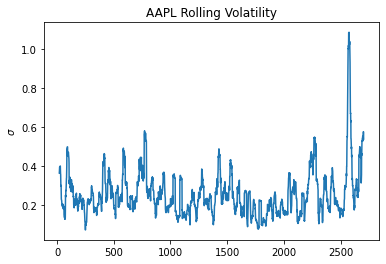

In [ ]:
print('Approximate volatility through the 10 years:',np.mean(df['rolling_sigma']))
df.rolling_sigma.plot()
plt.ylabel('$\sigma$')
plt.title('AAPL Rolling Volatility')

Another con of Black Scholes is the symmetry in the normal distribution not always verified with long/short tails underlying distribution. Adding to this the fact that the model underestimates the tail density, we get out-of-the-money options that are underestimated as shown below.

(-0.03, 0.03)

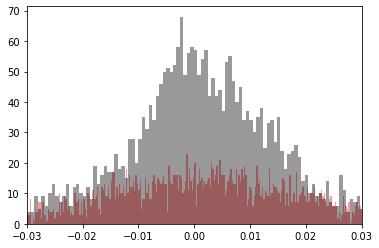

In [ ]:
std = df.change.std()
WT = np.random.normal(df.change.mean() ,std, size=len(df['change']))
plt.hist(np.exp(WT)-1,bins=500,color='red',alpha=0.4);
plt.hist(df.change,bins=400,color='black', alpha=0.4);
plt.xlim([-0.03,0.03])


Text(0, 0.5, 'Density')

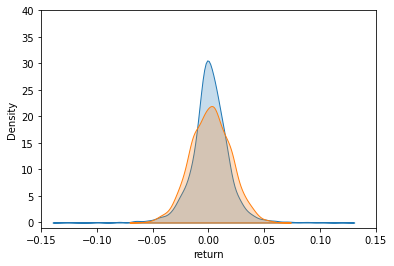

In [ ]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data=df['change'].dropna(), label='Empirical', ax=ax,shade=True)
ax = sns.kdeplot(data=WT, label='Log Normal', ax=ax,shade=True)
plt.xlim([-0.15,0.15])
plt.ylim([-1,40])
plt.xlabel('return')
plt.ylabel('Density')

# Test on three stoks AAPL, MSFT, WMT from 2010-01-01 to 2020-10-01

In [ ]:
stock_ticker_appl = 'AAPL'
stock_ticker_msft = 'MSFT'
stock_ticker_wmt = 'WMT'
start = pd.to_datetime(['2010-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2020-10-01']).astype(int)[0]//10**9 # convert to unix timestamp.
url_appl = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker_appl + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
url_msft = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker_msft + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
url_wmt = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker_wmt + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df_appl = pd.read_csv(url_appl)
df_appl['Stock'] = 'AAPL'
df_msft = pd.read_csv(url_msft)
df_msft['Stock'] = 'MSFT'
df_wmt = pd.read_csv(url_wmt)
df_wmt['Stock'] = 'WMT'
data = pd.concat([df_appl,df_msft,df_wmt])
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """


,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.526021,493729600,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.537304,601904800,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.433318,552160000,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.421425,477131200,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.464117,447610800,AAPL


In [ ]:
print('Number of empty stocks values \n',data.isna().sum())
print('Number of actions WMT:',len(data[data['Stock']=='WMT']))
print('Number of actions AAPL:',len(data[data['Stock']=='AAPL']))
print('Number of actions MSFT:',len(data[data['Stock']=='MSFT']))

Number of empty stocks values 
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Stock        0
dtype: int64
Number of actions WMT: 2705
Number of actions AAPL: 2705
Number of actions MSFT: 2705


In [ ]:
# create a new dataframe with 'date' column as index
new = data.set_index('Date')
# use pandas pivot function to sort adj_close by tickers
clean_data = new.pivot(columns='Stock')
# check the head of the output
clean_data.head()

Open                            High                        \
Stock           AAPL       MSFT        WMT      AAPL       MSFT        WMT   
Date                                                                         
2010-01-04  7.622500  30.620001  53.740002  7.660714  31.100000  54.669998   
2010-01-05  7.664286  30.850000  54.090000  7.699643  31.100000  54.189999   
2010-01-06  7.656429  30.879999  53.500000  7.686786  31.080000  53.830002   
2010-01-07  7.562500  30.629999  53.720001  7.571429  30.700001  53.750000   
2010-01-08  7.510714  30.280001  53.430000  7.571429  30.879999  53.529999   

                 Low                           Close                        \
Stock           AAPL       MSFT        WMT      AAPL       MSFT        WMT   
Date                                                                         
2010-01-04  7.585000  30.590000  53.669998  7.643214  30.950001  54.230000   
2010-01-05  7.616071  30.639999  53.570000  7.656429  30.959999  53.689999   
2010-01-06  7.526786  30.520000  53.419998  7.534643  30.770000  53.570000   
2010-01-07  7.466071  30.190001  53.259998  7.520714  30.450001  53.599998   
2010-01-08  7.466429  30.240000  53.020000  7.570714  30.660000  53.330002   

           Adj Close                           Volume                      
Stock           AAPL       MSFT        WMT       AAPL      MSFT       WMT  
Date                                                                       
2010-01-04  6.526021  23.800224  40.481712  493729600  38409100  20753100  
2010-01-05  6.537304  23.807919  40.078609  601904800  49749600  15648400  
2010-01-06  6.433318  23.661808  39.989040  552160000  58182400  12517200  
2010-01-07  6.421425  23.415728  40.011440  477131200  50559700  10662700  
2010-01-08  6.464117  23.577223  39.809883  447610800  51197400  11363200

As we are working with dividends we will consider the adjusted close instead of the close value. This way we will get a more accurate estimation of the stock value as the adjusted closing price begins where the closing price ends, it can be called a more accurate measure of stocks' value.

In [ ]:
close_columns = ['Adj Close']
clean_data_close = clean_data[close_columns]
clean_data_close.head()

Adj Close                      
Stock           AAPL       MSFT        WMT
Date                                      
2010-01-04  6.526021  23.800224  40.481712
2010-01-05  6.537304  23.807919  40.078609
2010-01-06  6.433318  23.661808  39.989040
2010-01-07  6.421425  23.415728  40.011440
2010-01-08  6.464117  23.577223  39.809883

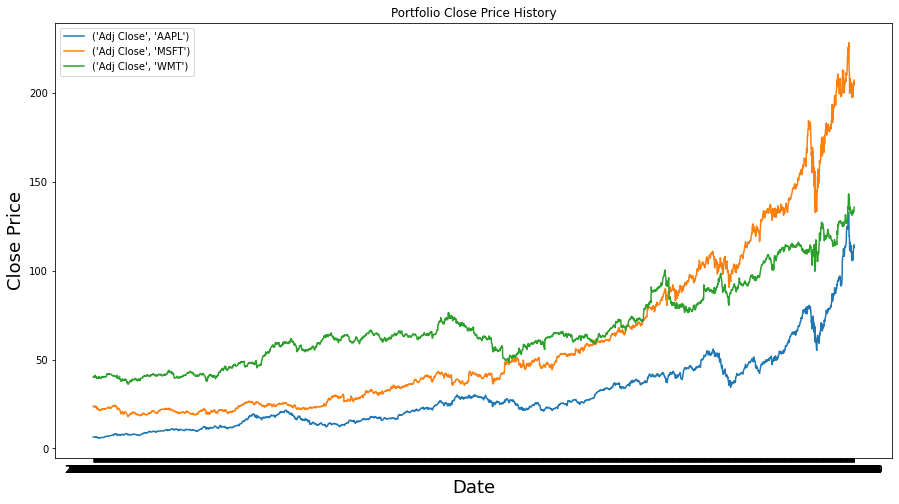

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
for i in clean_data_close.columns.values :
    ax.plot(clean_data_close[i], label = i)
ax.set_title("Portfolio Close Price History")
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Close Price' , fontsize=18)
ax.legend(clean_data_close.columns.values , loc = 'upper left')
plt.show(fig)

Correlation between Stocks in the portfolio


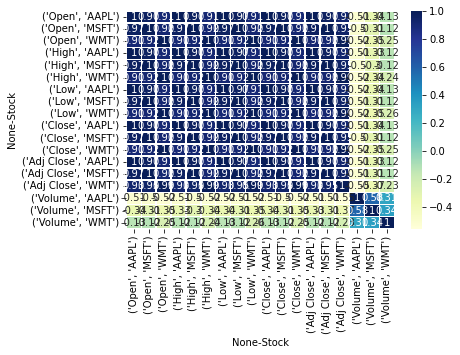

In [ ]:
correlation_matrix = clean_data.corr(method='pearson')
# print(correlation_matrix)
fig1 = plt.figure()
sns.heatmap(correlation_matrix,xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns,
cmap='YlGnBu', annot=True, linewidth=0.5)
print('Correlation between Stocks in the portfolio')
plt.show(fig1)

Daily simple returns


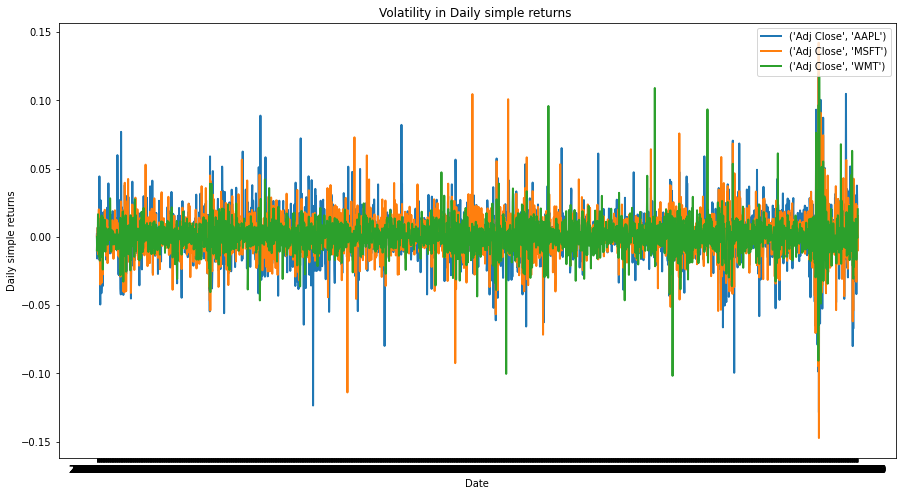

Average Daily returns in percentage of stocks in the portfolio
           Stock
Adj Close  AAPL     0.121721
           MSFT     0.092818
           WMT      0.051893
dtype: float64
Annualized Standard Deviation/Volatility over 2705 trading days of each stocks in the portfolio of daily simple returns.
           Stock
Adj Close  AAPL     0.922288
           MSFT     0.831259
           WMT      0.624435
dtype: float64


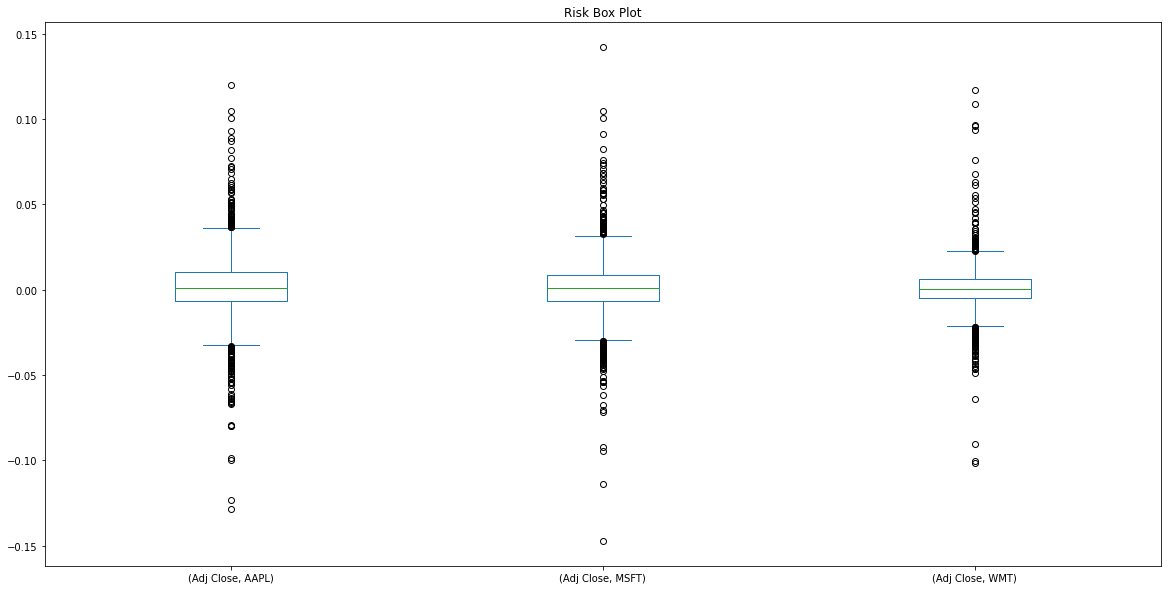

In [ ]:
# Get the proportion of variation of each stock each day.
daily_simple_return = clean_data_close.pct_change(1)
daily_simple_return.dropna(inplace=True)
# Visualize the resulting tab of stocks variations values
print('Daily simple returns')
fig, ax = plt.subplots(figsize=(15,8))
for i in daily_simple_return.columns.values :
    ax.plot(daily_simple_return[i],lw =2,label = i)
ax.legend(loc = 'upper right', fontsize =10)
ax.set_title('Volatility in Daily simple returns ')
ax.set_xlabel('Date')
ax.set_ylabel('Daily simple returns')
plt.show(fig)
print('Average Daily returns in percentage of stocks in the portfolio')
Avg_daily = daily_simple_return.mean()
print(Avg_daily*100)
daily_simple_return.plot(kind = "box",figsize = (20,10), title = "Risk Box Plot")
print(f'Annualized Standard Deviation/Volatility over {len(clean_data)} trading days of each stocks in the portfolio of daily simple returns.')
print(f'{daily_simple_return.std() * np.sqrt(len(clean_data))}')

# Plot of the options' price (calls and puts) estimated by Black-Scholes applied on Apple's stocks values recolted over a year on a daily basis.

In [ ]:
# We may compute an empirical rate of dividends paid. For the tests with Black-Scholes we will use the average rate.
qrate_tab =[]
for index,count in enumerate(clean_data_close[('Adj Close', 'AAPL')][0:276]):
  qrate_tab.append((clean_data['Close']-clean_data['Adj Close']).iloc[int(index)]/clean_data.iloc[int(index)]['Close']['AAPL'])
print(np.mean(qrate_tab))

0.7355454907368666


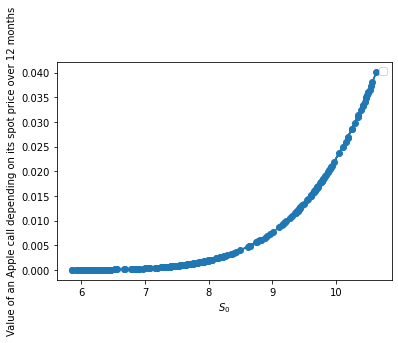

In [ ]:
S_AAPL = clean_data_close[0:276][('Adj Close', 'AAPL')] #[0:23] for a month so [0:276] for a year.
K = 8
T = 1
r = 0.01
q = np.mean(qrate_tab) # Empirical rate of dividends.
sigma = (daily_simple_return[0:276].std() * np.sqrt(len(clean_data_close[0:276])))[0] # The volatility of the AAPL stock over a year of trading.

calls = [black_scholes_dividends(S_AAPL, K, T, r,q,sigma,'call') for s in S_AAPL]
plt.plot(S_AAPL, calls[0:11][0],marker = 'o')
plt.xlabel('$S_0$')
plt.ylabel('Value of an Apple call depending on its spot price over 12 months')
plt.legend()

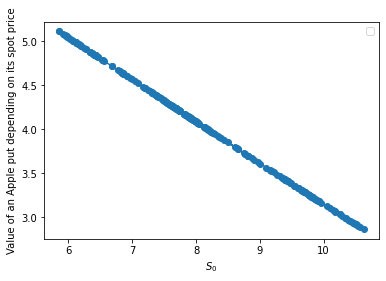

In [ ]:
puts = [black_scholes_dividends(S_AAPL, K, T, r,q,sigma,'put') for s in S_AAPL]
plt.plot(S_AAPL, puts[0:11][0],marker='o')
plt.xlabel('$S_0$')
plt.ylabel("Value of an Apple put depending on its spot price")
plt.legend()